<a href="https://colab.research.google.com/github/Jayden-Nyamiaka/Machine-Learning-and-Data-Mining/blob/main/nyamiaka_jayden_prob3_B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem 3 Sample Code

This sample code is meant as a guide on how to use PyTorch and how to use the relevant model layers. This not a guide on how to design a network and the network in this example is intentionally designed to have poor performace.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms

## Loading MNIST
The `torchvision` module contains links to many standard datasets. We can load the MNIST dataset into a `Dataset` object as follows:

In [ ]:
train_dataset = datasets.MNIST('./data', train=True, download=True,  # Downloads into a directory ../data
                               transform=transforms.ToTensor())
test_dataset = datasets.MNIST('./data', train=False, download=False,  # No need to download again
                              transform=transforms.ToTensor())

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



The `Dataset` object is an iterable where each element is a tuple of (input `Tensor`, target):

In [ ]:
print(len(train_dataset), type(train_dataset[0][0]), type(train_dataset[0][1]))

60000 <class 'torch.Tensor'> <class 'int'>


Examining the Input Data (3A)

In [ ]:
print("The training dataset has", len(train_dataset), "images with a tuple of (input Tensor, int target) for each image")
print("The testing dataset has", len(test_dataset), "images of similar representation")

first_img = train_dataset[0][0]
print("Each image has", len(first_img), "data structure that stores the representation of the image.")

print("Height of each image:", len(first_img[0]))
print("Width of each image:", len(first_img[0][0]))
print("Type for each float:", first_img[0][0][0].dtype)

The training dataset has 60000 images with a tuple of (input Tensor, int target) for each image
The testing dataset has 10000 images of similar representation
Each image has 1 data structure that stores the representation of the image.
Height of each image: 28
Width of each image: 28
Type for each float: torch.float32


We can convert images to numpy arrays and plot them with matplotlib:

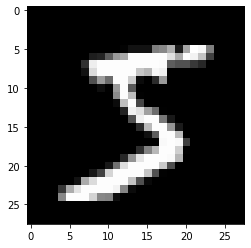

In [ ]:
plt.imshow(train_dataset[0][0][0].numpy(), cmap='gray')

## Network Definition
Let's instantiate a model and take a look at the layers.

In [ ]:
model = nn.Sequential(
    # In problem 2, we don't use the 2D structure of an image at all. Our network
    # takes in a flat vector of the pixel values as input.
    nn.Flatten(),  
    nn.Linear(784, 20),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(20, 10)
)
print(model)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=20, bias=True)
  (2): ReLU()
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=20, out_features=10, bias=True)
)


## Training
We also choose an optimizer and a loss function.

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

We could write our training procedure manually and directly index the `Dataset` objects, but the `DataLoader` object conveniently creates an iterable for automatically creating random minibatches:

In [ ]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True) 

We now write our backpropagation loop, training for 10 epochs.

In [ ]:
# Some layers, such as Dropout, behave differently during training
model.train()

for epoch in range(10):
    for batch_idx, (data, target) in enumerate(train_loader):
        # Erase accumulated gradients
        optimizer.zero_grad()

        # Forward pass
        output = model(data)

        # Calculate loss
        loss = loss_fn(output, target)

        # Backward pass
        loss.backward()
        
        # Weight update
        optimizer.step()

    # Track loss each epoch
    print('Train Epoch: %d  Loss: %.4f' % (epoch + 1,  loss.item()/len(train_loader)))

Train Epoch: 1  Loss: 0.0005
Train Epoch: 2  Loss: 0.0003
Train Epoch: 3  Loss: 0.0005
Train Epoch: 4  Loss: 0.0003
Train Epoch: 5  Loss: 0.0003
Train Epoch: 6  Loss: 0.0004
Train Epoch: 7  Loss: 0.0004
Train Epoch: 8  Loss: 0.0003
Train Epoch: 9  Loss: 0.0002
Train Epoch: 10  Loss: 0.0002


## Testing
We can perform forward passes through the network without saving gradients.

In [ ]:
# Putting layers like Dropout into evaluation mode
model.eval()

test_loss = 0
correct = 0

# Turning off automatic differentiation
with torch.no_grad():
    for data, target in test_loader:
        output = model(data)
        test_loss += loss_fn(output, target).item()  # Sum up batch loss
        pred = output.argmax(dim=1, keepdim=True)  # Get the index of the max class score
        correct += pred.eq(target.view_as(pred)).sum().item()

test_loss /= len(test_loader.dataset)

print('Test set: Average loss: %.4f, Accuracy: %d/%d (%.4f)' %
      (test_loss, correct, len(test_loader.dataset),
       100. * correct / len(test_loader.dataset)))

Test set: Average loss: 0.0095, Accuracy: 9210/10000 (92.1000)


## Finding Model Helper Functions

In [ ]:
# Some layers, such as Dropout, behave differently during training
def train_model(model, epochs, train_loader, optimizer, loss_fn):
  model.train()
  final_loss = 0
  for epoch in range(epochs):
      for batch_idx, (data, target) in enumerate(train_loader):
          # Erase accumulated gradients
          optimizer.zero_grad()

          # Forward pass
          output = model(data)

          # Calculate loss
          loss = loss_fn(output, target)

          # Backward pass
          loss.backward()
          
          # Weight update
          optimizer.step()

      # Updates loss for this epoch
      final_loss = loss.item() 
  avg_loss = final_loss / len(train_loader.dataset)
  return avg_loss

def evaluate_model(model, test_loader, loss_fn, printAccuracy):
  model.eval()
  test_loss = 0
  correct = 0
  # Turning off automatic differentiation
  with torch.no_grad():
      for data, target in test_loader:
          output = model(data)
          test_loss += loss_fn(output, target).item()  # Sum up batch loss
          pred = output.argmax(dim=1, keepdim=True)  # Get the index of the max class score
          correct += pred.eq(target.view_as(pred)).sum().item()
  avg_loss = test_loss / len(test_loader.dataset)
  eval_accuracy = 100. * correct / len(test_loader.dataset)
  if (printAccuracy):
    print('Accuracy: %d/%d (%.4f)' % (correct, len(test_loader.dataset), eval_accuracy) )
  return eval_accuracy

# Plots the neural net average test loss against the given x range
def plot_models(value_range, xlabel, ReLU_loss, Soft_loss, title):
  plt.figure() 

  plt.plot(value_range, ReLU_loss, marker = '.', color = "red") 
  plt.plot(value_range, Soft_loss, marker = '.', color = "blue")

  # Labels the figure
  plt.legend(['ReLU', 'Softmax'], loc = 'best')
  plt.xlabel(xlabel)
  plt.ylabel('Evaluation Accuracy (%)')
  plt.title(title)

  plt.show()

##Finding Optimal Number of Hidden Units

In [ ]:
# Set constants
epochs = 10
learning_rate = 1e-3
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True) 
loss_fn = nn.CrossEntropyLoss()

hidden_units = [*range(55, 101, 15)]
accuracyReLU = []
accuracySoft = []

for units in hidden_units:
  modelReLU = nn.Sequential(
    nn.Flatten(),  
    nn.Linear(784, units),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(units, 10)
  )
  optimizer = torch.optim.Adam(modelReLU.parameters(), lr=learning_rate)
  train_model(modelReLU, epochs, train_loader, optimizer, loss_fn)
  accuracyReLU.append( evaluate_model(modelReLU, test_loader, loss_fn, True) )

  modelSoft = nn.Sequential(
    nn.Flatten(),  
    nn.Linear(784, units),
    nn.Softmax(),
    nn.Dropout(0.5),
    nn.Linear(units, 10)
  )
  optimizer = torch.optim.Adam(modelSoft.parameters(), lr=learning_rate)
  train_model(modelSoft, epochs, train_loader, optimizer, loss_fn)
  accuracySoft.append( evaluate_model(modelSoft, test_loader, loss_fn, True) )

Accuracy: 9602/10000 (96.0200)


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Accuracy: 9204/10000 (92.0400)
Accuracy: 9680/10000 (96.8000)
Accuracy: 9291/10000 (92.9100)
Accuracy: 9713/10000 (97.1300)
Accuracy: 9297/10000 (92.9700)
Accuracy: 9700/10000 (97.0000)
Accuracy: 9325/10000 (93.2500)


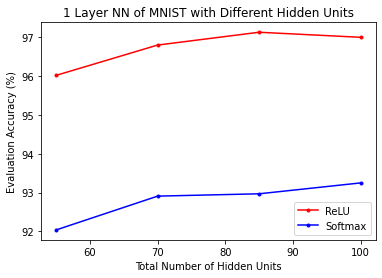

In [ ]:
plot_models(hidden_units, "Total Number of Hidden Units", accuracyReLU, accuracySoft, '1 Layer NN of MNIST with Different Hidden Units')

## Our Final Model

From our analysis and the graph above, we know our model performs better with the following parameters.

In [ ]:
torch.manual_seed(0)

epochs = 15

model = nn.Sequential(
  nn.Flatten(),  
  nn.Linear(784, 95),
  nn.ReLU(),
  nn.Dropout(0.5),
  nn.Linear(95, 10)
)
print(model)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True) 
  
train_model(model, epochs, train_loader, optimizer, loss_fn)
print("Accuracy of ReLU with 95 hidden units:", end = " ")
evaluate_model(model, test_loader, loss_fn, True)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=95, bias=True)
  (2): ReLU()
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=95, out_features=10, bias=True)
)
Accuracy of ReLU with 95 hidden units: Accuracy: 9754/10000 (97.5400)


97.54